In [568]:
import json
import numpy as np
import math

rawData = json.load(open('./data.json', 'r'))

In [569]:
%matplotlib inline

In [570]:
import matplotlib.pyplot as plt

In [571]:
forgeries = rawData['forgeries']
signatures = rawData['signatures']

In [572]:
forgeryMap = {}

for forgery in forgeries:
    target = forgery['target']
    data = forgery['data']
    
    if target not in forgeryMap:
        forgeryMap[target] = []
    
    forgeryMap[target].append(np.array([(f['ty'], f['ti'], f['x'], f['y']) for f in data]))

In [573]:
signatureMap = {}

for sign in signatures:
    nickname = sign['nickname']
    data = sign['data']
    
    if nickname not in signatureMap:
        signatureMap[nickname] = []
    
    signatureMap[nickname].append(np.array([(s['ty'], s['ti'], s['x'], s['y']) for s in data]))

In [574]:
def distance(sx, sy, dx, dy):
    return math.sqrt(
        ((dx-sx)**2)
        + ((dy-sy)**2)
    )

In [575]:
def standardForm(data, qc = 30, tqc = 100):
    qr = 1 / qc
    sig = data
    
    ty = sig[:,0]
    t = sig[:,1]
    x = sig[:,2]
    y = sig[:,3]

    mint = min(*t)
    maxt = max(*t)
    dt = maxt - mint

    t = (t - mint) / dt

    # Straighten
    [m, _] = np.polyfit(x, y, 1)
    points = np.array(list(zip(x, y)))

    delta = np.arctan(m)

    R = np.array([
        [np.cos(delta), -np.sin(delta)],
        [np.sin(delta), np.cos(delta)]
    ])

    pointsTransformed = points @ R
    x, y = pointsTransformed[:,0], pointsTransformed[:,1]

    # Normalize
    minx = min(*x)
    maxx = max(*x)
    dx = maxx - minx

    miny = min(*y)
    maxy = max(*y)
    dy = maxy - miny

    nx = (x - minx) / dx
    ny = (y - miny) / dy

    normalizedPoints = np.array(list(zip(nx, ny)))

    qx = np.array([np.round(i/qr)*qr for i in nx])
    qy = np.array([np.round(i/qr)*qr for i in ny])

    quantizedPoints = np.array(list(zip(qx, qy)))

    withExtraDimensions = []
    lastDist = 0
    liftCount = 0

    for i in range(len(quantizedPoints) - 1):
        s = i
        d = i + 1

        if ty[s] in [0, 1] and ty[d] == 1:
            dist = lastDist + math.sqrt(((qx[s] - qx[d]) ** 2) + ((qy[s] - qy[d]) ** 2))

            withExtraDimensions.append([
                t[s],    # From Time
                t[d],    # To Time
                lastDist, # From Dist
                dist,     # To Dist
                liftCount,# Lift #
                qx[s],    # SRC X
                qy[s],    # SRC Y
                qx[d],    # DST X
                qy[d]     # DST Y
            ])

            lastDist = dist

    totalDist = lastDist
    totalTime = 1
    
    distanceXY = []
    distanceV = []
    distancePhi = []
    
    timeXY = []
    timeV = []
    timePhi = []
    
    distQuant = totalDist / tqc
    timeQuant = totalTime / tqc

    k = 0
    for i in range(tqc):
        targetDist = i * distQuant
        found = False

        while k < len(withExtraDimensions):
            [ft, tt, fd, td, _, srcx, srcy, dstx, dsty] = withExtraDimensions[k]

            if targetDist > td:
                k = k + 1
                continue

            if td - fd == 0:
                k = k + 1
                continue

            r = (targetDist - fd) / (td - fd)
            xAtTarget = srcx + (dstx - srcx)*r
            yAtTarget = srcy + (dsty - srcy)*r
            found = True

            break

        if not found:
            distanceXY.append([-1, -1])
            distanceV.append(-1)
            distancePhi.append(-1)
        else:
            distanceXY.append([xAtTarget, yAtTarget])
            distanceV.append((td - fd) / (tt - ft))
            
            if dstx - srcx == 0:
                distancePhi.append(3)
            else:
                distancePhi.append(np.arctan((dsty - srcy) / (dstx - srcx)))

#     distanceXY = np.array(distanceXY)






    k = 0
    for i in range(tqc):
        targetTime = i * timeQuant
        found = False

        while k < len(withExtraDimensions):
            [ft, tt, fd, td, _, srcx, srcy, dstx, dsty] = withExtraDimensions[k]

            if targetTime > tt:
                k = k + 1
                continue

            if tt - ft == 0:
                k = k + 1
                continue

            r = (targetTime - ft) / (tt - ft)
            xAtTarget = srcx + (dstx - srcx)*r
            yAtTarget = srcy + (dsty - srcy)*r
            found = True

            break

        if not found:
            timeXY.append([-1, -1])
            timeV.append(-1)
            timePhi.append(-1)
        else:
            timeXY.append([xAtTarget, yAtTarget])
            timeV.append((td - fd) / (tt - ft))
            
            if dstx - srcx == 0:
                timePhi.append(3)
            else:
                timePhi.append(np.arctan((dsty - srcy) / (dstx - srcx)))

#     timeXY = np.array(timeXY)
    
    return [timeXY, distanceXY, distanceV, timeV, timePhi, distancePhi]

In [576]:
def col(arr, c):
    return [row[c] for row in arr]

def mean(stack):
    substack = []
    
    for n in stack:
        if n != -1:
            substack.append(n)

    return np.mean(substack)

def median(stack):
    substack = []
    
    for n in stack:
        if n != -1:
            substack.append(n)

    return np.median(substack)
                

def agregateSignatures(data, qc = 30, tqc = 100):
    arr = []
    
    for row in data:
        li = standardForm(row, qc, tqc)
        arr.append(li)
        
    mets = []

    for i in range(0, 2):
        metric = col(arr, i)

        a_mean = []
        a_median = []

        for j in range(tqc):
            pair = col(metric, j)
            
            a_mean.append([mean(col(pair, 0)), mean(col(pair, 1))])
            a_median.append([median(col(pair, 0)), median(col(pair, 1))])
            
        mets.append([a_mean, a_median])

    for i in range(2, 6):
        metric = col(arr, i)
        
        a_mean = []
        a_median = []
  
        for j in range(tqc):
            stack = col(metric, j)
            
            a_mean.append(mean(stack))
            a_median.append(median(stack))
            
        mets.append([a_mean, a_median])
        
    return mets
            



In [577]:
def errorDistances(a, b):
    a = np.array(a)
    b = np.array(b)
    
    dists = []
    
    for i in range(len(a)):
        if -1 in [a[i][0], a[i][1], b[i][0], b[i][1]]:
            dists.append(2)
        else:
            dists.append(
                numpy.linalg.norm(a[i]-b[i])
            )
        
    return dists

In [578]:
nickname = 'OMRAN'

0.1518917776572862

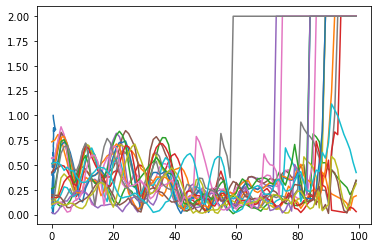

In [579]:
agregate = agregateSignatures(signatureMap[nickname])
plt.plot(mean_txy[:,0], mean_txy[:,1])

mean_txy = np.array(agregate[0][0])
medians = []

for forged in forgeryMap[nickname]:
    forgery = standardForm(forged)
    forge_txy = np.array(forgery[0])
    
    dists = errorDistances(mean_txy, forge_txy)
    medians.append(np.median(dists))
    
    plt.plot(dists)
    
np.min(medians)

0.14821495702592724

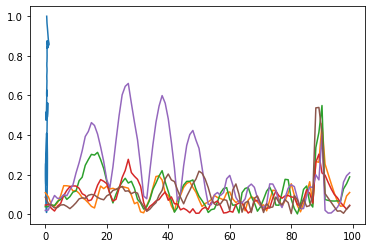

In [580]:
agregate = agregateSignatures(signatureMap[nickname])
plt.plot(mean_txy[:,0], mean_txy[:,1])

mean_txy = np.array(agregate[0][0])
medians = []

for forged in signatureMap[nickname]:
    forgery = standardForm(forged)
    forge_txy = np.array(forgery[0])
    
    dists = errorDistances(mean_txy, forge_txy)
    medians.append(np.median(dists))
    
    plt.plot(dists)
    
np.max(medians)

In [581]:
def compare(training, test, qc = 30, tc = 100):
    mean = agregateSignatures(training, qc, tc)[0][0]
    
    medians = []
    
    for own in training:
        standard_own = standardForm(own, qc, tc)[0]
        dists = errorDistances(mean, standard_own)
        
        medians.append(np.median(dists))
        
    max_median = np.max(medians)
    median = np.median(medians)
    thresh = (max_median + median) / 2
    
    standard_test = standardForm(test, qc, tc)[0]
    dists = errorDistances(mean, standard_test)
    
    match = True
    meddist = np.median(dists)
    
    if meddist > thresh:
        match = False
    
    return (match, thresh, meddist)

In [582]:
for name in ['SAMI', 'SAMIHA', 'OMRAN']:
    for own in signatureMap[name]:
        comparison = compare(signatureMap[name], own)
        
        print(comparison)

(False, 0.1712054180645588, 0.18449685308582228)
(False, 0.1712054180645588, 0.2378980093790687)
(True, 0.1712054180645588, 0.098110488824477)
(True, 0.1712054180645588, 0.15539266078079988)
(True, 0.1712054180645588, 0.12009556119779305)
(True, 0.1712054180645588, 0.09838889926930149)
(True, 0.1712054180645588, 0.11063675423079627)
(True, 0.1712054180645588, 0.07439266344525935)
(True, 0.1712054180645588, 0.09543321129445018)
(True, 0.1712054180645588, 0.09197169492684573)
(True, 0.12523986101594053, 0.11121568998426114)
(True, 0.12523986101594053, 0.089692660641521)
(True, 0.12523986101594053, 0.10121200557452181)
(False, 0.12523986101594053, 0.14926771645735926)
(True, 0.12523986101594053, 0.0941369667319649)
(True, 0.1198050013799821, 0.09139504573403696)
(True, 0.1198050013799821, 0.10423391525480649)
(True, 0.1198050013799821, 0.06810530149224968)
(False, 0.1198050013799821, 0.14821495702592724)
(True, 0.1198050013799821, 0.07831529915042117)


In [583]:
for name in ['SAMI', 'SAMIHA', 'OMRAN']:
    for forgery in forgeryMap[name]:
        comparison = compare(signatureMap[name], forgery)
        
        print(comparison)

(False, 0.1712054180645588, 0.3945246246467136)
(False, 0.1712054180645588, 0.7102686749632452)
(False, 0.1712054180645588, 2.0)
(False, 0.1712054180645588, 0.4037030550780031)
(False, 0.1712054180645588, 0.35659445407525814)
(False, 0.1712054180645588, 2.0)
(False, 0.12523986101594053, 0.2327024047385886)
(False, 0.12523986101594053, 0.30577588577015713)
(False, 0.12523986101594053, 0.3611558607093693)
(False, 0.12523986101594053, 0.3109218024983642)
(False, 0.12523986101594053, 0.5191356716245248)
(False, 0.12523986101594053, 0.30190250805879076)
(False, 0.12523986101594053, 0.43497042402315306)
(False, 0.12523986101594053, 0.3170501280009448)
(False, 0.12523986101594053, 0.23781879623154017)
(False, 0.12523986101594053, 0.2444638796247216)
(False, 0.12523986101594053, 0.5605107979254168)
(False, 0.12523986101594053, 0.49269604554305113)
(False, 0.12523986101594053, 2.0)
(False, 0.1198050013799821, 0.23707735009180053)
(False, 0.1198050013799821, 0.18067282759394246)
(False, 0.119805